In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/bitcoin-historical-data/bitstampUSD_1-min_data_2012-01-01_to_2021-03-31.csv


in this case study I will use the Bitcoin historical data from year 2012 to 2021, and after preparing data to analyze I will use some machine learning models to predict the future price


## Import Libraries

In [2]:
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import MinMaxScaler
from sklearn.feature_selection import VarianceThreshold
from sklearn.model_selection import cross_val_score, train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import StratifiedKFold
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error
from sklearn.svm import SVC
import statsmodels.api as sm
from sklearn.metrics import r2_score, mean_absolute_percentage_error

In [3]:
# Load dataset
url = '/kaggle/input/bitcoin-historical-data/bitstampUSD_1-min_data_2012-01-01_to_2021-03-31.csv'
BTC_df = pd.read_csv(url)
BTC_df.head()

,Timestamp,Open,High,Low,Close,Volume_(BTC),Volume_(Currency),Weighted_Price
0,1325317920,4.39,4.39,4.39,4.39,0.455581,2.0,4.39
1,1325317980,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,1325318040,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,1325318100,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,1325318160,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [4]:
# printing informarion about data frame and calculating descriprive statistics
print(BTC_df.shape)
BTC_df.info()
BTC_df.describe()

(4857377, 8)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4857377 entries, 0 to 4857376
Data columns (total 8 columns):
 #   Column             Dtype  
---  ------             -----  
 0   Timestamp          int64  
 1   Open               float64
 2   High               float64
 3   Low                float64
 4   Close              float64
 5   Volume_(BTC)       float64
 6   Volume_(Currency)  float64
 7   Weighted_Price     float64
dtypes: float64(7), int64(1)
memory usage: 296.5 MB


,Timestamp,Open,High,Low,Close,Volume_(BTC),Volume_(Currency),Weighted_Price
count,4.857377e+06,3.613769e+06,3.613769e+06,3.613769e+06,3.613769e+06,3.613769e+06,3.613769e+06,3.613769e+06
mean,1.471301e+09,6.009024e+03,6.013357e+03,6.004488e+03,6.009014e+03,9.323249e+00,4.176284e+04,6.008935e+03
std,8.428019e+07,8.996247e+03,9.003521e+03,8.988778e+03,8.996360e+03,3.054989e+01,1.518248e+05,8.995992e+03
min,1.325318e+09,3.800000e+00,3.800000e+00,1.500000e+00,1.500000e+00,0.000000e+00,0.000000e+00,3.800000e+00
25%,1.398179e+09,4.438600e+02,4.440000e+02,4.435200e+02,4.438600e+02,4.097759e-01,4.521422e+02,4.438306e+02
50%,1.471428e+09,3.596970e+03,3.598190e+03,3.595620e+03,3.597000e+03,1.979811e+00,3.810124e+03,3.596804e+03
75%,1.544288e+09,8.627270e+03,8.632980e+03,8.621090e+03,8.627160e+03,7.278216e+00,2.569821e+04,8.627637e+03
max,1.617149e+09,6.176356e+04,6.178183e+04,6.167355e+04,6.178180e+04,5.853852e+03,1.390067e+07,6.171621e+04


## Data Cleaning

finding the NANs cells and removing them

reset the index and check the new shape of data frame

In [5]:
# Identify Missig Values

BTC_df.isnull().sum()

Timestamp                  0
Open                 1243608
High                 1243608
Low                  1243608
Close                1243608
Volume_(BTC)         1243608
Volume_(Currency)    1243608
Weighted_Price       1243608
dtype: int64

it is shown that the 25% of our data has missing value ( 1243608 out of 4857377 )

there is many strategies that we can do:

* deleting the missing rows and make the model to 75% of our dataset


In [6]:
# Drop nan rows from dataset

BTC_cleaned = BTC_df.dropna()
print(BTC_cleaned.shape)
BTC_cleaned.info()
BTC_cleaned.isna().sum()

(3613769, 8)
<class 'pandas.core.frame.DataFrame'>
Index: 3613769 entries, 0 to 4857376
Data columns (total 8 columns):
 #   Column             Dtype  
---  ------             -----  
 0   Timestamp          int64  
 1   Open               float64
 2   High               float64
 3   Low                float64
 4   Close              float64
 5   Volume_(BTC)       float64
 6   Volume_(Currency)  float64
 7   Weighted_Price     float64
dtypes: float64(7), int64(1)
memory usage: 248.1 MB


Timestamp            0
Open                 0
High                 0
Low                  0
Close                0
Volume_(BTC)         0
Volume_(Currency)    0
Weighted_Price       0
dtype: int64

In [7]:
# droping the duplicates
BTC_cleaned.drop_duplicates()
BTC_cleaned.shape

(3613769, 8)

## Data Preprocessing

In [8]:
# reset the index of dataset

BTC_cleaned.reset_index(inplace=True, drop=True)

# converting to the right formats

#BTC_cleaned['Timestamp'] = pd.to_datetime(BTC_cleaned['Timestamp'], unit='s')
#BTC_replaced['Timestamp'] = pd.to_datetime(BTC_replaced['Timestamp'], unit='s')


# printing the information of each

BTC_cleaned.info()
BTC_cleaned.head()



<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3613769 entries, 0 to 3613768
Data columns (total 8 columns):
 #   Column             Dtype  
---  ------             -----  
 0   Timestamp          int64  
 1   Open               float64
 2   High               float64
 3   Low                float64
 4   Close              float64
 5   Volume_(BTC)       float64
 6   Volume_(Currency)  float64
 7   Weighted_Price     float64
dtypes: float64(7), int64(1)
memory usage: 220.6 MB


,Timestamp,Open,High,Low,Close,Volume_(BTC),Volume_(Currency),Weighted_Price
0,1325317920,4.39,4.39,4.39,4.39,0.455581,2.000000,4.390000
1,1325346600,4.39,4.39,4.39,4.39,48.000000,210.720000,4.390000
2,1325350740,4.50,4.57,4.50,4.57,37.862297,171.380338,4.526411
3,1325350800,4.58,4.58,4.58,4.58,9.000000,41.220000,4.580000
4,1325391360,4.58,4.58,4.58,4.58,1.502000,6.879160,4.580000


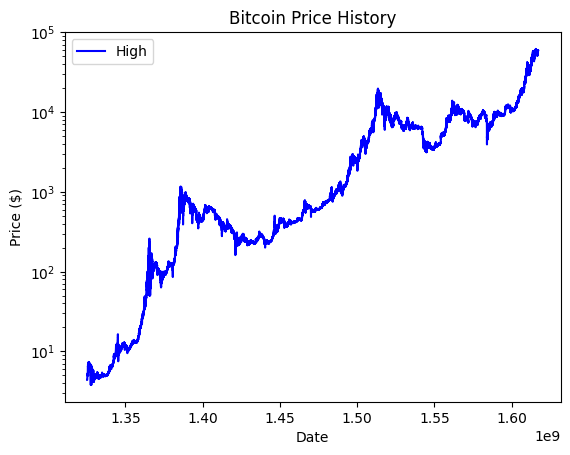

In [9]:
BTC_cleaned.plot(kind = 'line', color = 'b',x="Timestamp",y="High", logy=True)
plt.title('Bitcoin Price History')
plt.xlabel('Date')
plt.ylabel('Price ($)')
plt.show()


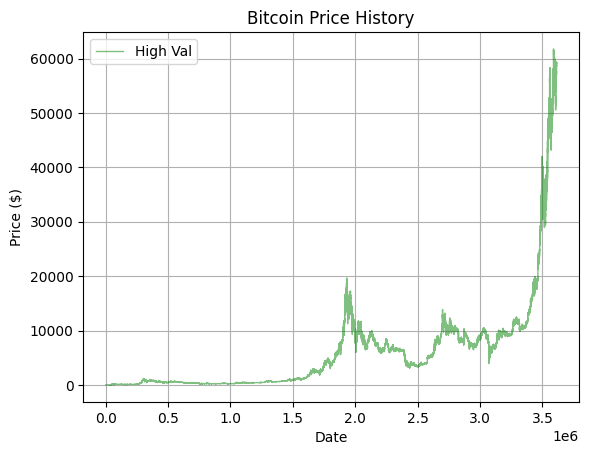

In [10]:
BTC_cleaned.High.plot(kind = 'line', color = 'g',label = 'High Val',linewidth=1,alpha = 0.5,grid = True,linestyle = '-')
plt.legend(loc='upper left')     # legend = puts label into plot
plt.title('Bitcoin Price History')
plt.xlabel('Date')
plt.ylabel('Price ($)')
plt.show()

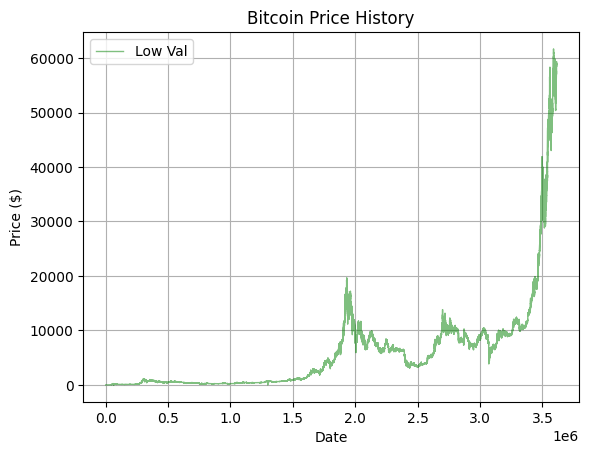

In [11]:
BTC_cleaned.Low.plot(kind = 'line', color = 'g',label = 'Low Val',linewidth=1,alpha = 0.5,grid = True,linestyle = '-')
plt.legend(loc='upper left')     # legend = puts label into plot
plt.title('Bitcoin Price History')
plt.xlabel('Date')
plt.ylabel('Price ($)')
plt.show()

### making train and test datasets

In [12]:
BTC_cleaned.head()

,Timestamp,Open,High,Low,Close,Volume_(BTC),Volume_(Currency),Weighted_Price
0,1325317920,4.39,4.39,4.39,4.39,0.455581,2.000000,4.390000
1,1325346600,4.39,4.39,4.39,4.39,48.000000,210.720000,4.390000
2,1325350740,4.50,4.57,4.50,4.57,37.862297,171.380338,4.526411
3,1325350800,4.58,4.58,4.58,4.58,9.000000,41.220000,4.580000
4,1325391360,4.58,4.58,4.58,4.58,1.502000,6.879160,4.580000


In [13]:
# Train Test Split

features = ['Open', 'Low', 'Volume_BTC', 'Volume_USD']
target = 'High'

BTC_cleaned.rename(columns = {'Volume_(BTC)':'Volume_BTC', 'Volume_(Currency)':'Volume_USD'}, inplace = True)
BTC_cleaned_final = BTC_cleaned[features + [target]]

array = BTC_cleaned_final.values
X = array[:, 0:4]
y = array[:, 4]

X_train, X_valid, y_train, y_valid = train_test_split(X, y, train_size=0.8, test_size=0.2, random_state=0)

print(X_train.shape)
print(X_valid.shape)


/tmp/ipykernel_18/1041278077.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  BTC_cleaned.rename(columns = {'Volume_(BTC)':'Volume_BTC', 'Volume_(Currency)':'Volume_USD'}, inplace = True)


(2891015, 4)
(722754, 4)


In [14]:
BTC_cleaned_final.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3613769 entries, 0 to 3613768
Data columns (total 5 columns):
 #   Column      Dtype  
---  ------      -----  
 0   Open        float64
 1   Low         float64
 2   Volume_BTC  float64
 3   Volume_USD  float64
 4   High        float64
dtypes: float64(5)
memory usage: 137.9 MB


* Apply the random forest regression model to the data set

In [15]:
model = RandomForestRegressor(n_estimators=50, random_state=0)
model.fit(X_train, y_train)

# Get validation predictions and MAE
preds_valid = model.predict(X_valid)
print("MAE (Your approach):")
print(mean_absolute_error(y_valid, preds_valid))

MAE (Your approach):
3.433940925976648


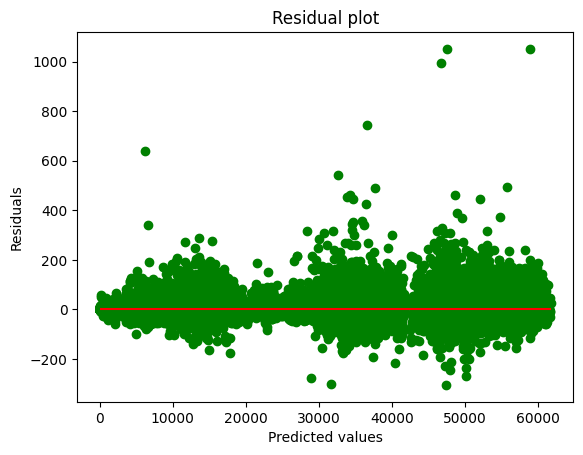

In [16]:

residuals = y_valid - preds_valid

plt.scatter(preds_valid, residuals, color='green')
plt.hlines(y=0, xmin=0, xmax=max(preds_valid), color='red')
plt.title('Residual plot')
plt.xlabel('Predicted values')
plt.ylabel('Residuals')
plt.show()

* Apply the linear regression model to the data set

In [17]:
model = LinearRegression()
model.fit(X_train, y_train)

# Get validation predictions and MAE
preds_valid_2 = model.predict(X_valid)
print("MAE (Your approach):")
print(mean_absolute_error(y_valid, preds_valid_2))

MAE (Your approach):
3.9756394682392036


In [18]:

model = LinearRegression()
model.fit(X_train, y_train)

# Get validation predictions and MAE
preds_valid_3 = model.predict(X_valid)
print("MAE (Your approach):")
print(mean_absolute_error(y_valid, preds_valid_3))

MAE (Your approach):
3.9756394682392036


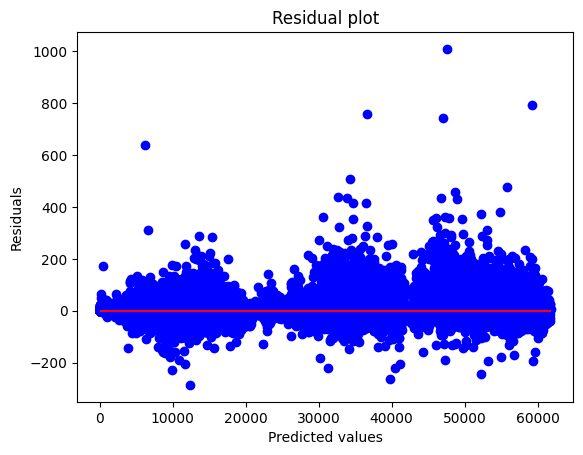

In [19]:
residuals = y_valid - preds_valid_2

plt.scatter(preds_valid_2, residuals, color='blue')
plt.hlines(y=0, xmin=0, xmax=max(preds_valid_2), color='red')
plt.title('Residual plot')
plt.xlabel('Predicted values')
plt.ylabel('Residuals')
plt.show()